# Translation model from COCO -> MPII


In [2]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from lovely_numpy import lo
import scipy
import json

/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth_val_set = json.load(f)

with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii_valset.json', 'r') as f:
    annot_pred_coco_val_set = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)



In [66]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  # skip = False
  # for joint_vis in annot_truth[i]['joints_vis']:
  #   if joint_vis == 0:
  #     skip = True
  #     break
  # if skip:
  #   continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (22246, 17, 2)
y shape: (22246, 16, 2)
box scale: (22246,)
box center: (22246, 2)


In [ ]:
lo(X).plt

array[22246, 17, 2] n=756364 (5.8Mb) x∈[-328.556, 2.048e+03] μ=532.795 σ=325.546

In [ ]:
lo(y).plt

array[22246, 16, 2] n=711872 (5.4Mb) x∈[-38.767, 1.936e+03] μ=499.185 σ=335.099

How many negative examples are there on each of those (negative doesn't mean anything, except for -1 for 1 where it's non-visible)

In [67]:
print((X < 0).sum())
print(((y < 0) & (y != -1)).sum())
negative_x_mask = np.any(X[:,:,0] <= 0, axis=1) | np.any(X[:,:,1] <= 0, axis=1)

X_clean = X[~negative_x_mask]
y_clean = y[~negative_x_mask]

negative_y_mask = np.any(
  (y_clean[:,:,0] <= 0) & (y_clean[:,:,0] != -1), axis=1
  ) | np.any((y_clean[:,:,1] <= 0) & (y_clean[:,:,1] != -1), axis=1)
X_clean = X_clean[~negative_y_mask]
y_clean = y_clean[~negative_y_mask]

box_scale_clean = box_scale[~negative_x_mask]
box_scale_clean = box_scale_clean[~negative_y_mask]

box_center_clean = box_center[~negative_x_mask]
box_center_clean = box_center_clean[~negative_y_mask]

print(X_clean.shape)
print(y_clean.shape)


425
325
(21768, 17, 2)
(21768, 16, 2)


## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

In [71]:
# box_scale = N x 1
# box_center = N x 2
# N x 16 x 2

# needs masking on normalization as well
# to not use not joint visible points
def unnormalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  data = copy.deepcopy(data)

  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data *= bbox_width[:, np.newaxis, :]
  data += bbox_left[:, np.newaxis, :]
  if isinstance(mask, np.ndarray):
    data = data * mask
    # To make back to -1
    data = data + (-1) * (1 - mask)

  return data

def normalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  # first width & height, but they are the same
  data = copy.deepcopy(data)
  # bbleft point N x 2
  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data -= bbox_left[:, np.newaxis, :] 
  data /= bbox_width[:, np.newaxis, :]
 
  if isinstance(mask, np.ndarray):
      data = data * mask
      # To make back to -1
      data = data + (-1) * (1 - mask)
  return data
  # bbright point
  # return data
X_normalized = normalize(X_clean, box_center=box_center_clean, box_scale=box_scale_clean)
y_normalized = normalize(y_clean, box_center=box_center_clean, box_scale=box_scale_clean, mask=(y_clean != -1))
lo(y_normalized)

array[21768, 16, 2] n=696576 (5.3Mb) x∈[-1.159, 1.230] μ=0.402 σ=0.397

In [72]:
print((y == unnormalize(normalize(y, box_center=box_center, box_scale=box_scale, mask=(y != -1)), 
                        box_center=box_center, box_scale=box_scale, mask=(y != -1))).sum() != 0)

True


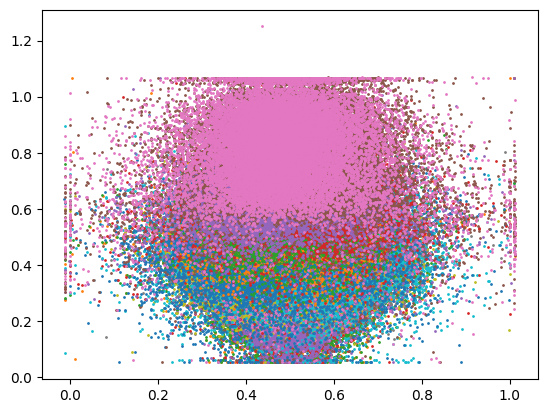

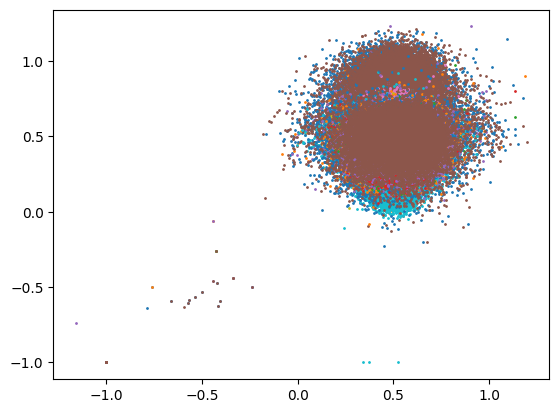

In [73]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Display outliers in normalized env

array[21768, 17, 2] n=740112 (5.6Mb) x∈[-0.013, 1.250] μ=0.493 σ=0.160


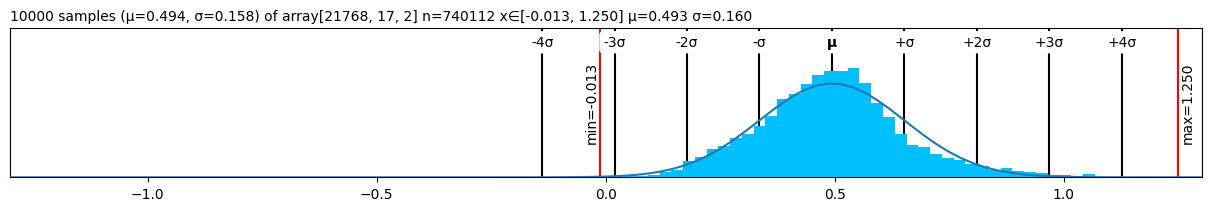

In [74]:
print(lo(X_normalized))
lo(X_normalized).plt

array[21768, 16, 2] n=696576 (5.3Mb) x∈[-1.159, 1.230] μ=0.402 σ=0.397


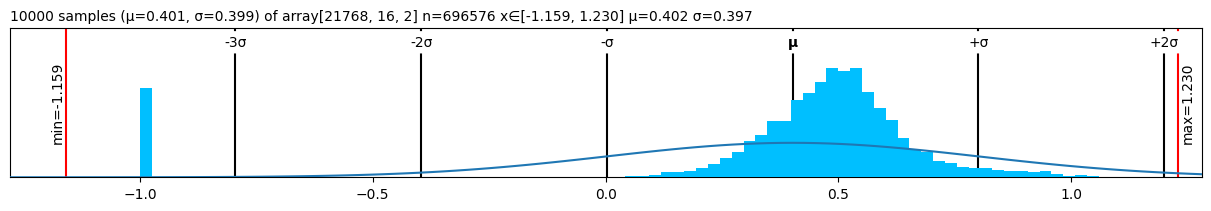

In [75]:
print(lo(y_normalized))
lo(y_normalized).plt

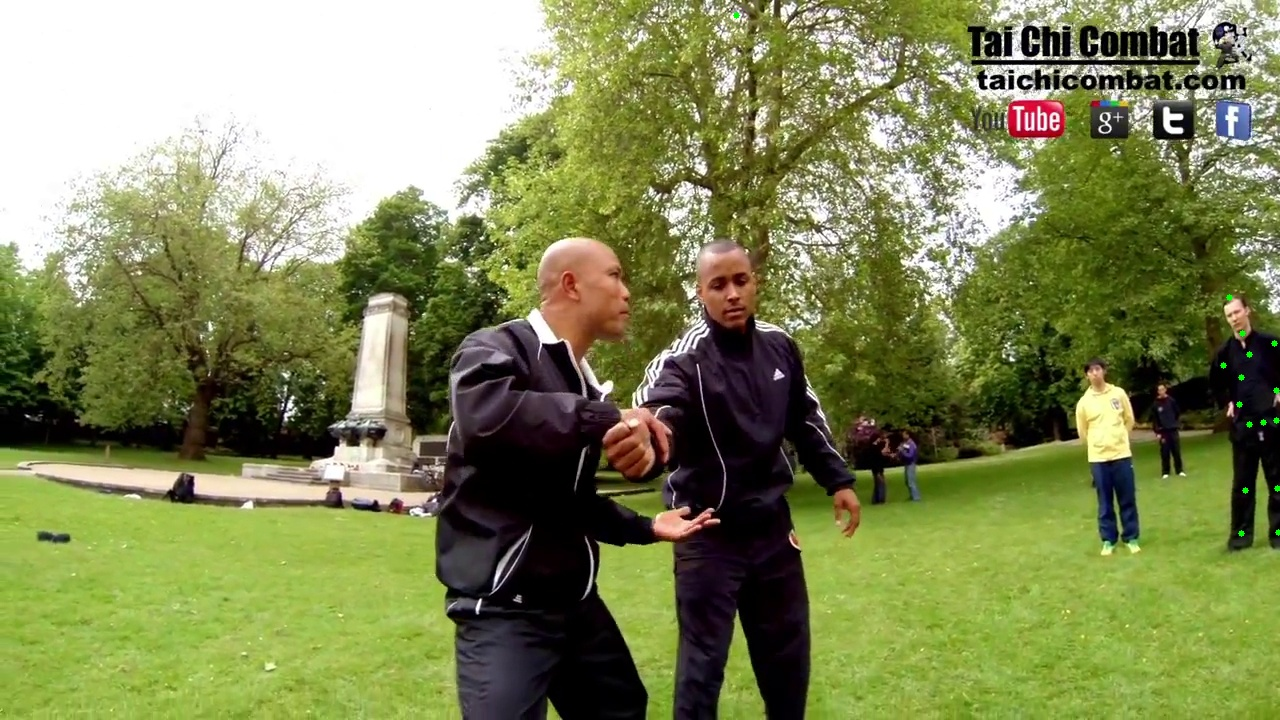

In [10]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

# from utils import display_kp_image
from IPython.display import Image, display
import cv2

outlier_index = np.argmin(y_normalized)
index = np.unravel_index(outlier_index, y_normalized.shape)

def display_kp_image(im_path, keypoints):

  image = cv2.imread(im_path)

  for kp in keypoints:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'images/tm_results/image_test0.jpg', image)

  display(Image(filename=f'images/tm_results/image_test0.jpg'))

display_kp_image(ROOT_FOLDER+'/data/MPII_COCO/images/'+annot_truth[index2orig[index[0]]]['image'],
                annot_truth[index2orig[index[0]]]['joints']
                 )

## Outlier images from coco prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


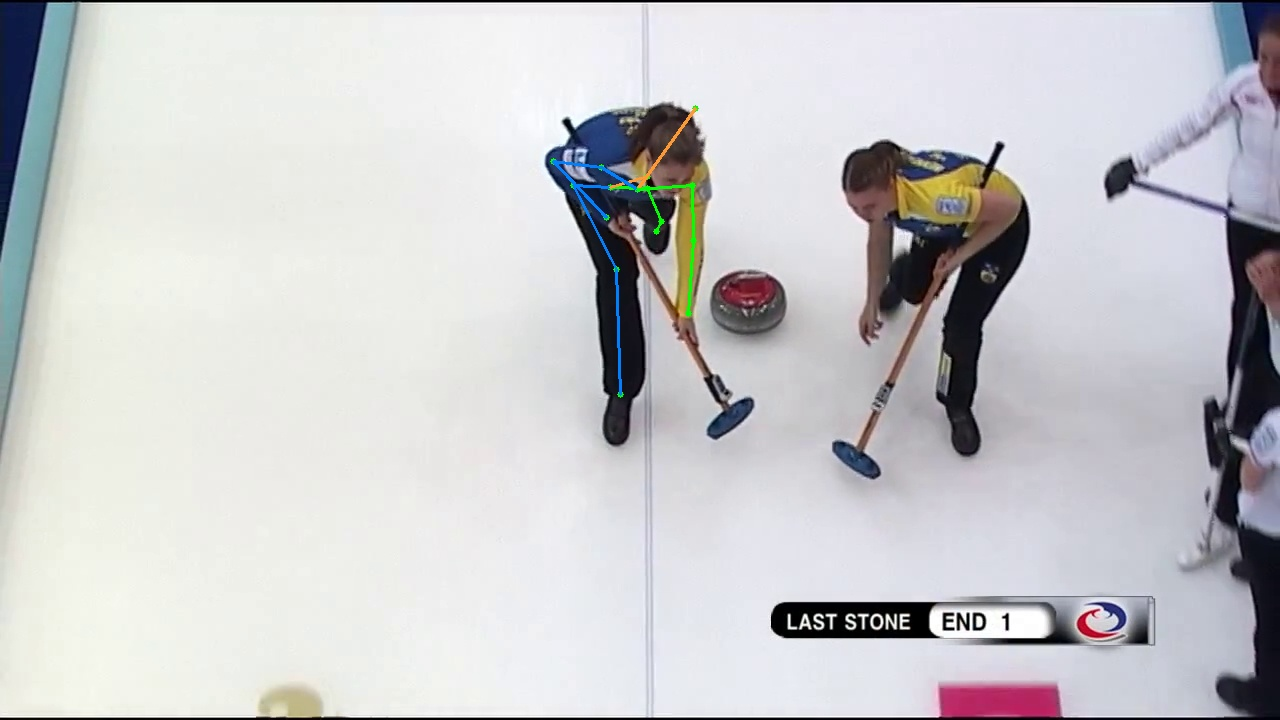

In [11]:
%load_ext autoreload
%autoreload 2

from visualize import visualize_with_keypoints, save_with_keypoints

visualize_with_keypoints(0, annot_truth, annot_truth[0]['joints'])

In [25]:
# N x 17 x 2
index = 0
count = 0
for row in range(y_normalized.shape[0]):
  
  for col in range(y_normalized.shape[1]):
    # Heads
      if y_normalized[row, col, 1] < 0 and y_normalized[row, col, 1] != -1:
        print("heree")
        save_with_keypoints(nth_image=row,
                           annot_truth=annot_truth, 
                           path = f'images/outliers/image{annot_truth[row]["image"]}',
                           keypoints=y[row],
                           skeleton=None,
                           bounding_box=(annot_truth[row]["center"],annot_truth[row]["scale"])
                           )
      index += 1  
# print("On the boundary: ", count)


heree
059741310.jpg
bbleft: (248, 7)
bbright: (673, 432)
heree
005142581.jpg
bbleft: (24, 202)
bbright: (645, 823)
heree
005142581.jpg
bbleft: (174, 99)
bbright: (1061, 986)
heree
049636625.jpg
bbleft: (852, 248)
bbright: (1727, 1123)
heree
024667886.jpg
bbleft: (462, 562)
bbright: (811, 911)
heree
099180995.jpg
bbleft: (710, 488)
bbright: (941, 719)
heree
086456361.jpg
bbleft: (1531, 186)
bbright: (2020, 675)
heree
066243401.jpg
bbleft: (771, 69)
bbright: (1146, 444)
heree
053157215.jpg
bbleft: (225, 71)
bbright: (548, 394)
heree
097915156.jpg
bbleft: (468, 0)
bbright: (865, 397)
heree
086141805.jpg
bbleft: (266, 49)
bbright: (549, 332)
heree
095238675.jpg
bbleft: (285, 92)
bbright: (562, 369)
heree
062873402.jpg
bbleft: (236, 209)
bbright: (747, 720)
heree
078069930.jpg
bbleft: (593, 138)
bbright: (1290, 835)
heree
098617680.jpg
bbleft: (508, 75)
bbright: (1173, 740)
heree
070858355.jpg
bbleft: (240, 234)
bbright: (663, 657)
heree
097894736.jpg
bbleft: (216, 41)
bbright: (609, 434)
h

# PCK Accuracy implementation

In [66]:
def printAllPCKh(predict, gt):
    if isinstance(predict, torch.Tensor):
        predict = predict.cpu().numpy()
    if isinstance(gt, torch.Tensor):
        gt = gt.cpu().numpy()
    total_keypoints = gt.shape[0] * gt.shape[1]

    distances = np.linalg.norm((gt - predict), axis=-1)
    head_length = np.linalg.norm((gt[:, 8] - gt[:, 9]), axis=-1) * 0.5 * 0.6

    correct_classified = distances < head_length[:, np.newaxis]
    print(f'Head {(100 * correct_classified[:, 9].sum()) / total_keypoints : .2f}%')
    # correct_classified = np.sum(correct_classified, axis=-1)

    # percentage = correct_classified.sum() / total_keypoints
    # return percentage.item()
# printAllPCKh(y_normalized, y_normalized)

In [76]:
# Given prediction and ground truth with of Nx16x2, where N is sample num return PCKh score.
def calculatePCKh(predict, gt):
    if torch.is_tensor(predict) and torch.is_tensor(gt):
        # Only use values that are defined
        mask = gt != -1
        _gt = gt * mask
        _predict = predict * mask
        distances = torch.norm((_gt - _predict), dim=-1)
        head_length = torch.norm((_gt[:, 8] - _gt[:, 9]), dim=-1) * 0.5 * 0.6
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        correct_classified = distances < head_length[:, None]
        correct_classified = torch.sum(correct_classified, dim=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
        return percentage.item()

    else:
        mask = gt != -1
        _gt = gt * mask
        _predict = predict * mask
        distances = np.linalg.norm((_gt - _predict), axis=-1)
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        head_length = np.linalg.norm((_gt[:, 8] - _gt[:, 9]), axis=-1) * 0.5 * 0.6
        correct_classified = distances < head_length[:, np.newaxis]
        correct_classified = np.sum(correct_classified, axis=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
    return percentage


calculatePCKh(y_normalized, y_normalized)

0.9949007717750827

In [77]:
uv_error = np.ones((100, 16, 2))
uv_err = np.linalg.norm(uv_error, axis=1)
uv_err.shape

(100, 2)

## Define baseline accuracy

In [78]:
# Fake X identity base/ Direct COCO->MPII
mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
# Mergeable points merge
X_mpii_identity = np.ones_like(y)
for mpii_key, coco_key in mapping.items():
  X_mpii_identity[:,mpii_key] = X[:,coco_key]
# pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
X_mpii_identity[:,6] = (X_mpii_identity[:,2]+X_mpii_identity[:,3])/2
# thorax (To define baseline, thorax is almost in the middle of left and right shoulder)
X_mpii_identity[:,7] = (X_mpii_identity[:,12]+X_mpii_identity[:,13])/2
X_mpii_identity[:,8] = (X_mpii_identity[:,7]+X[:,0])/2
X_mpii_identity[:,9] = (X[:, 1] + X[:, 2] ) / 2

print(calculatePCKh(X_mpii_identity, y))


0.800385462555066


## Split train, val, test

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_normalized, y_normalized, test_size=0.15, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32)


Train instance:  18502
Val instance:  3266
torch.Size([18502, 17, 2])
torch.Size([18502, 16, 2])
torch.Size([3266, 17, 2])
torch.Size([3266, 16, 2])


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(2*17, 256)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(256, 512)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(512, 512)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(512, 256)
        self.act4 = nn.ReLU()
        self.hidden5 = nn.Linear(256, 256)
        self.act5 = nn.ReLU()
        self.output = nn.Linear(256, 2*16)
    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act5(self.hidden5(x))
        x = self.output(x)
        return x.view(-1, 16, 2)

def init_model():
    return TranslatorNN().to(device)

In [81]:
def train_model(model, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    mask = targets != -1
                    loss = criterion(outputs * mask, targets * mask)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            mask = targets != -1
            loss = criterion(outputs * mask, targets * mask)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataset)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                mask = targets != -1
                loss = criterion(outputs * mask, targets * mask)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                accuracy += (calculatePCKh(outputs, targets))
        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [82]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [0.05]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model()
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model,lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.4f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



1 [{'lr': 0.05, 'epoch': 200}]
Training for param: {'lr': 0.05, 'epoch': 200}
TranslatorNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=34, out_features=256, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=256, out_features=512, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=512, out_features=512, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=512, out_features=256, bias=True)
  (act4): ReLU()
  (hidden5): Linear(in_features=256, out_features=256, bias=True)
  (act5): ReLU()
  (output): Linear(in_features=256, out_features=32, bias=True)
)
Epoch [0/200], Val Loss: 0.473842
Epoch [1/200], Train Loss: 0.122033, Val Loss: 0.064527 Accuracy: 19.72%
Epoch [11/200], Train Loss: 0.048854, Val Loss: 0.047438 Accuracy: 32.48%
Epoch [21/200], Train Loss: 0.035157, Val Loss: 0.038499 Accuracy: 40.82%
Epoch [31/200], Train Loss: 0.031505, Val Loss: 0.034262 Accuracy: 47.53%
Epoch [41/200], Train Loss: 0.028070, Val Loss: 0.028

KeyboardInterrupt: 

In [87]:
print(best_accuracy)

0.8704383514011053


In [86]:
print(best_params)
print(best_epoch)
print(best_accuracy)

{'lr': 0.05, 'epoch': 200}
190
0.8704383514011053


## Eval on test set

In [32]:
torch.save(best_model.state_dict(), 'models/best_translation_model3.pth')

In [46]:
def load_model_if_not_defined():
    try:
        best_model
    except NameError:
        # Load your model here
        best_model = TranslatorNN()
        best_model.load_state_dict(torch.load('./models/best_translation_model_tanh.pth', map_location=device))
        return model
best_model = load_model_if_not_defined()

In [50]:
best_model.to(device)

TranslatorNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=34, out_features=4096, bias=True)
  (act1): Tanh()
  (hidden2): Linear(in_features=4096, out_features=4096, bias=True)
  (act2): Tanh()
  (hidden3): Linear(in_features=4096, out_features=2048, bias=True)
  (act3): Tanh()
  (hidden4): Linear(in_features=2048, out_features=2048, bias=True)
  (act4): Tanh()
  (hidden5): Linear(in_features=2048, out_features=2048, bias=True)
  (act5): Tanh()
  (output): Linear(in_features=2048, out_features=32, bias=True)
)

In [88]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

X_test = list()
y_test = list()
test_box_scale = list()
test_box_center = list()

for i in range(len(annot_truth_val_set)):
  X_test.append(annot_pred_coco_val_set['annotations'][i]['joints'])
  y_test.append(annot_truth_val_set[i]['joints'])
  test_box_scale.append(annot_truth_val_set[i]['scale'])
  test_box_center.append(annot_truth_val_set[i]['center'])

X_test = np.array(X_test)
y_test = np.array(y_test)
test_box_scale = np.array(test_box_scale)
test_box_center = np.array(test_box_center)

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)


gt_dict = scipy.io.loadmat(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_gt_val.mat')



X_test:  (2958, 17, 2)
y_test:  (2958, 16, 2)


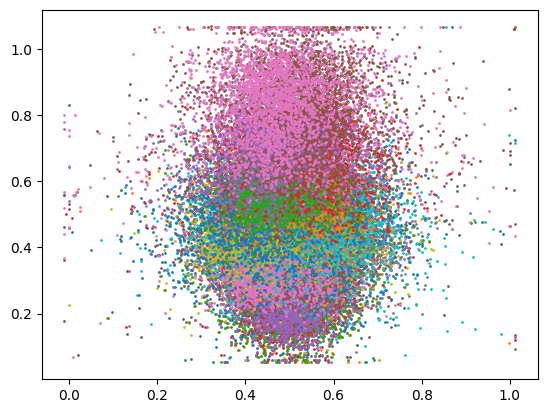

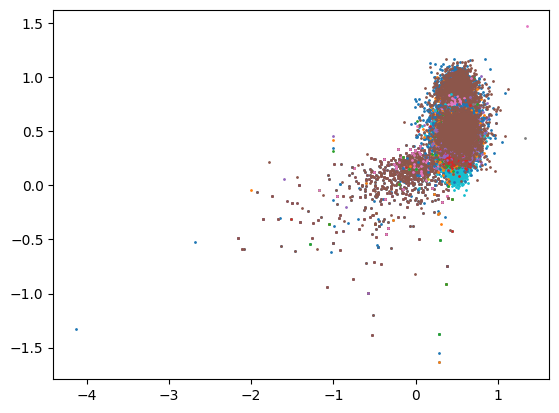

In [100]:
X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
y_test_normalized = normalize(y_test, test_box_center, test_box_scale, scale_px=200*1.25, mask = (y_test!=1))

for i in range(17):
  plt.scatter(X_test_normalized[:, i, 0],X_test_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_test_normalized[:, i, 0],y_test_normalized[:, i, 1], s=1)
plt.show()

In [89]:
best_model.eval()

with torch.no_grad():
  X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
  X_test_feed_in = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)

  prediction = best_model(X_test_feed_in) 
print("Pred: ", prediction.shape)

Pred:  torch.Size([2958, 16, 2])


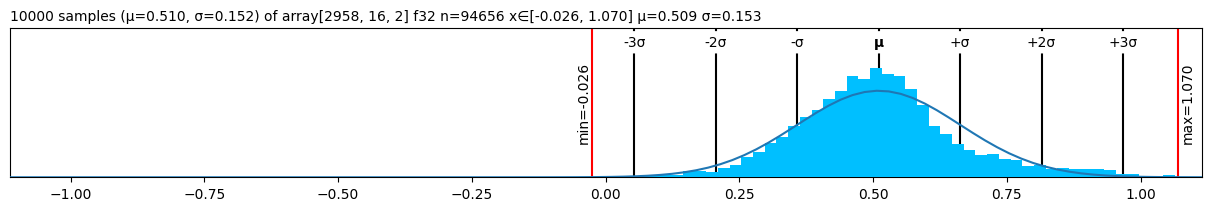

In [90]:
lo(np.array(prediction.cpu())).plt

In [91]:
dataset_joints = gt_dict['dataset_joints']
jnt_missing = gt_dict['jnt_missing']
pos_gt_src = gt_dict['pos_gt_src']
headboxes_src = gt_dict['headboxes_src']

pos_pred_src = unnormalize(prediction.cpu(), 
                           box_center=test_box_center,
                           box_scale=test_box_scale,
                           )
pos_pred_src = np.transpose(pos_pred_src.cpu(), [1, 2, 0])

head = np.where(dataset_joints == 'head')[1][0]
lsho = np.where(dataset_joints == 'lsho')[1][0]
lelb = np.where(dataset_joints == 'lelb')[1][0]
lwri = np.where(dataset_joints == 'lwri')[1][0]
lhip = np.where(dataset_joints == 'lhip')[1][0]
lkne = np.where(dataset_joints == 'lkne')[1][0]
lank = np.where(dataset_joints == 'lank')[1][0]

rsho = np.where(dataset_joints == 'rsho')[1][0]
relb = np.where(dataset_joints == 'relb')[1][0]
rwri = np.where(dataset_joints == 'rwri')[1][0]
rkne = np.where(dataset_joints == 'rkne')[1][0]
rank = np.where(dataset_joints == 'rank')[1][0]
rhip = np.where(dataset_joints == 'rhip')[1][0]

SC_BIAS = 0.6
threshold = 0.5

jnt_visible = 1 - jnt_missing
uv_error = pos_pred_src - pos_gt_src

uv_err = np.linalg.norm(uv_error, axis=1)
headsizes = headboxes_src[1, :, :] - headboxes_src[0, :, :]
headsizes = np.linalg.norm(headsizes, axis=0)
headsizes *= SC_BIAS
scale = headsizes * np.ones((len(uv_err), 1), dtype=np.float32)
scaled_uv_err = uv_err / scale
scaled_uv_err = scaled_uv_err * jnt_visible
jnt_count = np.sum(jnt_visible, axis=1)
less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
PCKh = 100. * np.sum(less_than_threshold, axis=1) / jnt_count

# save
rng = np.arange(0, 0.5 + 0.01, 0.01)
pckAll = np.zeros((len(rng), 16), dtype=np.float32)

for r, threshold in enumerate(rng):
    less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
    pckAll[r, :] = 100. * np.sum(
        less_than_threshold, axis=1) / jnt_count

PCKh = np.ma.array(PCKh, mask=False)
PCKh.mask[6:8] = True

jnt_count = np.ma.array(jnt_count, mask=False)
jnt_count.mask[6:8] = True
jnt_ratio = jnt_count / np.sum(jnt_count).astype(np.float64)

name_value = [('Head', PCKh[head]),
              ('Shoulder', 0.5 * (PCKh[lsho] + PCKh[rsho])),
              ('Elbow', 0.5 * (PCKh[lelb] + PCKh[relb])),
              ('Wrist', 0.5 * (PCKh[lwri] + PCKh[rwri])),
              ('Hip', 0.5 * (PCKh[lhip] + PCKh[rhip])),
              ('Knee', 0.5 * (PCKh[lkne] + PCKh[rkne])),
              ('Ankle', 0.5 * (PCKh[lank] + PCKh[rank])),
              ('PCKh', np.sum(PCKh * jnt_ratio)),
              ('PCKh@0.1', np.sum(pckAll[10, :] * jnt_ratio))]
for val in name_value:
    print(f'{val[0]}: {val[1]:.2f}%')


Head: 93.21%
Shoulder: 95.28%
Elbow: 89.28%
Wrist: 84.72%
Hip: 87.87%
Knee: 85.43%
Ankle: 82.40%
PCKh: 88.88%
PCKh@0.1: 27.66%


In [ ]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

In [75]:
pos_gt_src.shape

(16, 2, 2958)

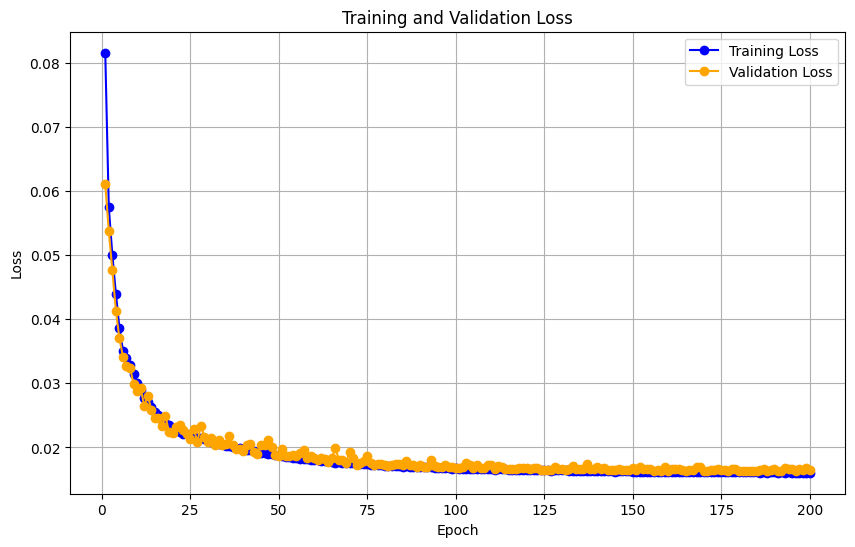

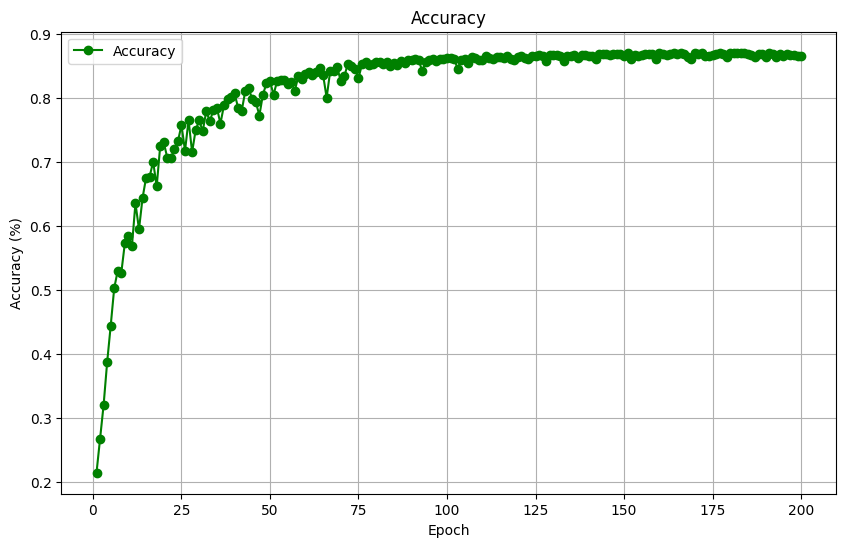

In [92]:
# Training and validation statistics
epochs = [val[0] for val in best_model_logs]
train_losses = [val[1] for val in best_model_logs]
val_losses = [val[2] for val in best_model_logs]
accuracies = [val[3] for val in best_model_logs]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Display some images from translation model

In [93]:
import cv2
from IPython.display import Image, display
from info import MPII_INFO
dataset_info = MPII_INFO()

In [94]:
# dataset_info['skeleton_info']
kps_name2index = {dataset_info['keypoint_info'][key]['name']:key for key in dataset_info['keypoint_info'] }
print(kps_name2index)


{'right_ankle': 0, 'right_knee': 1, 'right_hip': 2, 'left_hip': 3, 'left_knee': 4, 'left_ankle': 5, 'pelvis': 6, 'thorax': 7, 'upper_neck': 8, 'head_top': 9, 'right_wrist': 10, 'right_elbow': 11, 'right_shoulder': 12, 'left_shoulder': 13, 'left_elbow': 14, 'left_wrist': 15}


In [95]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)


NUM_IMAGES = 10

# choose image from ground truth
def choose_n_images(gt_json):
  random_numbers = np.random.randint(0, len(gt_json), size=10)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  print(annot_truth[index]['center'])
  print(annot_truth[index]['scale'])
  print(keypoints1)

  points = np.array(annot_pred_coco['annotations'][index]['joints'])
  points = (points - np.array(annot_truth[index]['center'])) / annot_truth[index]['scale']
  points = standardize(points)
  print(points.shape)
  points = torch.tensor(points, dtype=torch.float32)
  points = points.unsqueeze(0)
  keypoints2 = None
  print(points.shape)
  best_model.eval()
  with torch.no_grad():
    points = points.to(device)
    keypoints2 = best_model(points)

  keypoints2 = keypoints2.squeeze()
  # print(np.array(annot_truth[index]['joints']))
  keypoints2 = keypoints2.to('cpu')
  keypoints2 = np.array(keypoints2)
  keypoints2 = unstandardize(keypoints2)

  keypoints2 = annot_truth[index]['scale'] * keypoints2
  keypoints2 = keypoints2 + np.array(annot_truth[index]['center'])

  print("PCKh: ", calculatePCKh(torch.tensor(keypoints2, dtype=torch.float32).unsqueeze(0),
                                torch.tensor(annot_truth[index]['joints'], dtype=torch.float32).unsqueeze(0) ))

  print(keypoints2.shape)
  # Draw keypoints on the image
  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  for kp in keypoints2:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

  print(keypoints1)
  for id,val in dataset_info['skeleton_info'].items():
      # if int(keypoints1[kps_name2index[val['link'][0]]][0])  == -1:
      #   continue
      # if int(keypoints1[kps_name2index[val['link'][1]]][0])  == -1:
      #   continue
      start_point = (int(keypoints2[kps_name2index[val['link'][0]]][0] )), int(keypoints2[kps_name2index[val['link'][0]]][1])
      end_point = (int(keypoints2[kps_name2index[val['link'][1]]][0] )), int(keypoints2[kps_name2index[val['link'][1]]][1])
      cv2.line(image, start_point, end_point, val['color'], 2)  # Yellow color for lines
  # Resize the image if necessary
  # This step is optional, depending on your images

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image{index}.jpg', image)

  display(Image(filename=f'tm_results/image{index}.jpg'))


6314 069007535.jpg
[469.0, 554.0]
2.774466
[[101.0, 516.0], [221.0, 677.0], [363.0, 559.0], [346.0, 516.0], [245.0, 598.0], [110.0, 494.0], [355.0, 538.0], [576.0, 501.0], [582.0637, 500.3003], [673.9363, 489.6997], [608.0, 670.0], [572.0, 557.0], [589.0, 513.0], [563.0, 489.0], [500.0, 559.0], [587.0, 590.0]]


NameError: name 'standardize' is not defined

# Try building simple regressors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


In [ ]:
from sklearn import linear_model

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_stacked = np.reshape(X_train, (X_train.shape[0], -1))
print(X_train_stacked.shape)
X_val_stacked = np.reshape(X_val, (X_val.shape[0], -1))
print(X_val_stacked.shape)
print('y_val: ', y_val.shape)

for point in range(16):
  y_train_point = y_train[:, point]
  clf_x = linear_model.LinearRegression()
  clf_y = linear_model.LinearRegression()

  clf_x.fit(X_train_stacked, y_train_point[:, 0])
  clf_y.fit(X_train_stacked, y_train_point[:, 1])

  prediction_x = clf_x.predict(X_val_stacked)
  prediction_y = clf_y.predict(X_val_stacked)

  pred = np.stack((prediction_x, prediction_y), axis=1)
  error = ((pred - y_val[:, point]) ** 2).mean(axis = 1)
  # print(error[:10])
  error = np.mean(error)
  print(f'Error {point}: {error}')

    

(7861, 34)
(2621, 34)
y_val:  (2621, 16, 2)
Error 0: 224.21932983398438
Error 1: 94.02581024169922
Error 2: 57.048316955566406
Error 3: 58.99836730957031
Error 4: 89.52011108398438
Error 5: 235.37953186035156
Error 6: 46.26677322387695
Error 7: 25.42369842529297
Error 8: 27.508214950561523
Error 9: 55.37346267700195
Error 10: 188.04627990722656
Error 11: 76.92213439941406
Error 12: 42.63243103027344
Error 13: 43.588462829589844
Error 14: 81.3226089477539
Error 15: 133.448974609375


In [ ]:
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape)
print(y_val.shape)

(2621, 17, 2)
(2621, 16, 2)


In [ ]:
print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
print((abs(X_val[:, 14] - y_val[:, 1])).mean(axis=0))
# Around head location
print((abs(X_val[:, 0] - y_val[:, 9])).mean(axis=0))

# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))


[5.7771764 6.6435676]
[4.1824436 5.1991277]
[ 6.9651403 18.852098 ]
